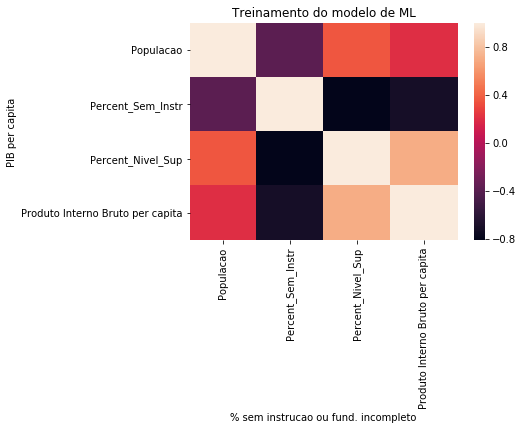

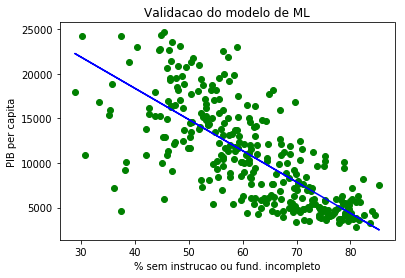

array([[23646.73092129]])

In [118]:
import pandas as pd
import os
os.chdir('D:\\BASES\\PIB')
caminho = str(os.getcwd())
caminho

# Importação do dataset - PIB Municípios 2010
pib_per_capita = pd.read_excel(caminho + '\PIB_Municipios_2010.xls')
pib_per_capita = pib_per_capita[pib_per_capita['Ano']==2010] # Filtro apenas para o ano de 2010
pib_per_capita = pib_per_capita[['Codigo do Municipio','Nome do Municipio','Produto Interno Bruto per capita']]
pib_per_capita['Codigo do Municipio'] = pib_per_capita['Codigo do Municipio'].astype(str).str[0:7]


# Importação do dataset - População de 25 anos ou mais residente dos municípios - Censo 2010
pop_acima25 = pd.read_excel(caminho + '\pop_acima_25.xlsx')
pop_acima25_agr = pop_acima25[['Cod_Municipio','Populacao']].groupby(['Cod_Municipio']).agg({'Populacao':'sum'}).reset_index()
pop_acima25_agr['Cod_Municipio'] = pop_acima25_agr['Cod_Municipio'].astype(str).str[0:7]

# Importação do dataset - Pessoas com 25 anos ou mais, sem instrução ou com ensino fundamental incompleto
sem_instr_acima25 = pd.read_excel(caminho + '\Sem_Instr_Fund_Incompleto.xlsx')
sem_instr_acima25

# Importação do dataset - Pessoas com 25 anos ou mais, com curso superior completo ou acima
superior_acima25 = pd.read_excel(caminho + '\Superior_Completo.xlsx')
superior_acima25

# Altera tipo de dados do campo Cod_Municipio
sem_instr_acima25['Cod_Municipio'] = sem_instr_acima25['Cod_Municipio'].astype(str).str[0:7]
superior_acima25['Cod_Municipio']  = superior_acima25 ['Cod_Municipio'].astype(str).str[0:7]

# Junta os datasets com níveis de instrução com a população de cada município
pop_nivel_instr = pd.merge(pop_acima25_agr, sem_instr_acima25, on='Cod_Municipio') # Pop acima de 25 x Pop acima de 25 sem instr
pop_nivel_instr = pd.merge(pop_nivel_instr,superior_acima25,on='Cod_Municipio') # Pop acima de 25 superior

# Calcula os percentuais de nível de instrução na população de 25 anos ou mais
pop_nivel_instr['Percent_Sem_Instr'] = pop_nivel_instr['Qt_Sem_Instr'] * 100 / pop_nivel_instr['Populacao']
pop_nivel_instr['Percent_Nivel_Sup'] = pop_nivel_instr['Qt_Nivel_Sup'] * 100 / pop_nivel_instr['Populacao']

#pop_nivel_instr[['Cod_Municipio','Municipio_x','Percent_Sem_Instr','Percent_Nivel_Sup']] #Seleciona as colunas relevantes

# Junta com o dataset do PIB dos Municípios 2010
pop_nivel_instr_pib = pd.merge(pop_nivel_instr,pib_per_capita,left_on='Cod_Municipio',right_on='Codigo do Municipio')
pop_nivel_instr_pib = pop_nivel_instr_pib[['Cod_Municipio','Municipio','Populacao','Percent_Sem_Instr','Percent_Nivel_Sup',
                                           'Produto Interno Bruto per capita']] #Seleciona as colunas relevantes


#pop_nivel_instr_pib.sort_values('Percent_Nivel_Sup',ascending=1).head(10)
#pop_nivel_instr_pib.sort_values('Produto Interno Bruto per capita',ascending=0).head(8)
#pop_nivel_instr_pib.sort_values('Populacao',ascending=0).head(20)

#import matplotlib.pyplot as plt

# Gráfico de dispersão: Pessoas com 25 anos ou mais sem instrução x PIB per capita
#pop_nivel_instr_pib.plot.scatter('Populacao','Produto Interno Bruto per capita',color='green')
#pop_nivel_instr_pib.plot('Populacao','Produto Interno Bruto per capita',color='blue')

# Retira municípios com pop abaixo de 10000
pop_nivel_instr_pib = pop_nivel_instr_pib[pop_nivel_instr_pib['Populacao']>=10000] 

# Retira municípios com PIB per capita acima de 25000
pop_nivel_instr_pib = pop_nivel_instr_pib[pop_nivel_instr_pib['Produto Interno Bruto per capita']<=25000] 

# Confirma quantidade de registros no dataset final
pop_nivel_instr_pib.count() # 1565

# Cálculo da correlação (formato tabular)
correlacao=pop_nivel_instr_pib.corr(method='pearson')

# Plotagem do mapa de calor da correlação
import seaborn as sns
sns.heatmap(correlacao, 
        xticklabels=correlacao.columns,
       yticklabels=correlacao.columns)

import matplotlib.pyplot as plt
X = pop_nivel_instr_pib.iloc[:,3] # 4º coluna: Percent_Sem_Instr - variável preditora
Y = pop_nivel_instr_pib.iloc[:,5] # 6ª coluna: PIB - variável resposta
plt.scatter(X, Y, color = 'green')
plt.title('Escolaridade e PIB per capita')
plt.xlabel('% sem instr. ou fund. incompleto')
plt.ylabel('PIB per capita')

# MODELO DE MACHINE LEARNING - REGRESSÃO LINEAR SIMPLES

##########################################################################
# 1) Sem instrução x PIB Per Capita 
##########################################################################
# Importa biblioteca Sickit Learn
import sklearn.model_selection as ms
import sklearn.linear_model as lm
import matplotlib.pyplot as plt

# Define as variáveis preditora e resposta do Dataset
X = pop_nivel_instr_pib.iloc[:,3] # 4º coluna: Percent_Sem_Instr - variável preditora
Y = pop_nivel_instr_pib.iloc[:,5] # 6ª coluna: PIB - variável resposta

# Separa base de treino e de teste
X_train, X_test, Y_train, Y_test = ms.train_test_split(X, Y, test_size=0.2, random_state = 0) # 80% da base para treino
X_train = X_train.values.reshape(-1, 1)
Y_train = Y_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
Y_test = Y_test.values.reshape(-1, 1)

# Treinando o modelo
regressor = lm.LinearRegression()
regressor.fit(X_train, Y_train)

# Previsão
Y_pred = regressor.predict(X_test)

# Visualizando o treino
plt.scatter(X_train, Y_train, color = 'green')
plt.plot(X_train, regressor.predict(X_train), color = 'blue')
plt.title('Treinamento do modelo de ML')
plt.xlabel('% sem instrucao ou fund. incompleto')
plt.ylabel('PIB per capita')
plt.show()

# Visualizando o teste
plt.scatter(X_test, Y_test, color = 'green')
plt.plot(X_test, regressor.predict(X_test), color = 'blue')
plt.title('Validacao do modelo de ML')
plt.xlabel('% sem instrucao ou fund. incompleto')
plt.ylabel('PIB per capita')
plt.show()

# Previsão com um valor específico
previsao_pib = regressor.predict([[25]])
previsao_pib